In [1]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from fastfm import als

C:\Users\funny\AppData\Local\Temp\ipykernel_17608\2803862566.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [3]:
# 加载数据到surprise库
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

In [4]:
# 划分训练集和测试集
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# 使用SVD算法
algo = SVD()
# 训练模型
algo.fit(trainset)
# 在测试集上进行预测
predictions = algo.test(testset)

RMSE: 0.8720


In [5]:
# 提取真实评分和预测评分
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]
# 转换为二分类问题，假设评分大于等于4为正类，其余为负类
y_true_binary = np.array([1 if x >= 3.5 else 0 for x in y_true])
y_pred_binary = np.array([1 if x >= 3.5 else 0 for x in y_pred])

In [6]:
# 将电影ID设置为索引以便快速查找
movies.set_index('MovieID', inplace=True)

Accuracy: 0.7397996420751642
Precision: 0.7668432876944598
Recall: 0.786534147232222


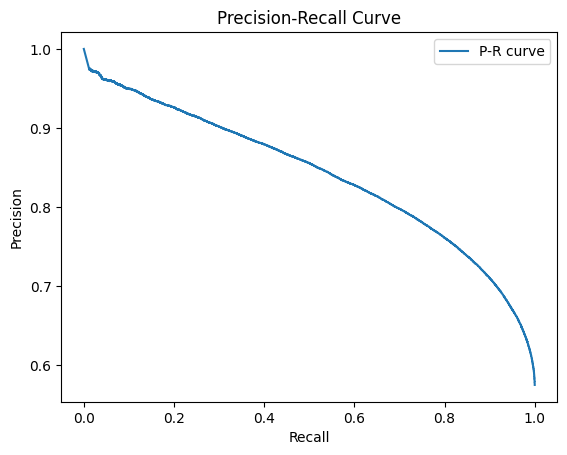

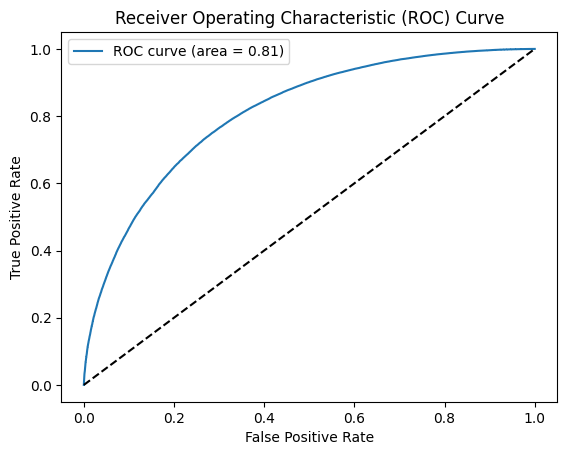

In [7]:
# 计算准确率、精确率、召回率
accuracy_score = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# 计算RMSE
rmse = accuracy.rmse(predictions)
# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)
# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [8]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    # 预测未评分电影的评分
    predictions = [algo.predict(user_id, item_id) for item_id in items_to_predict]
    # 按预测评分排序
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    # 返回前N个推荐
    top_n_recommendations = recommendations[:n]
    # 获取推荐电影的名字和类型
    results = []
    for pred in top_n_recommendations:
        movie_id = pred.iid
        movie_title = movies.loc[movie_id]['Title']
        movie_genres = movies.loc[movie_id]['Genres']
        results.append((movie_id, movie_title, movie_genres, pred.est))
    return results
# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")

Top 10 recommendations for user ID 1:
Movie ID: 2324, Title: Life Is Beautiful (La Vita è bella) (1997), Genres: Comedy|Drama, Predicted Rating: 4.898035330610544
Movie ID: 858, Title: Godfather, The (1972), Genres: Action|Crime|Drama, Predicted Rating: 4.879023846170111
Movie ID: 668, Title: Pather Panchali (1955), Genres: Drama, Predicted Rating: 4.852561534197712
Movie ID: 905, Title: It Happened One Night (1934), Genres: Comedy, Predicted Rating: 4.78393835247032
Movie ID: 1276, Title: Cool Hand Luke (1967), Genres: Comedy|Drama, Predicted Rating: 4.768593594751669
Movie ID: 2019, Title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954), Genres: Action|Drama, Predicted Rating: 4.753503506092023
Movie ID: 1234, Title: Sting, The (1973), Genres: Comedy|Crime, Predicted Rating: 4.738538363473262
Movie ID: 1250, Title: Bridge on the River Kwai, The (1957), Genres: Drama|War, Predicted Rating: 4.736268114656282
Movie ID: 318, Title: Shawshank Redemption, The (1994), Ge

In [ ]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [ ]:
# 对用户的性别、职业、邮政编码进行编码
label_encoders = {}
for column in ['Gender', 'Occupation', 'Zip-code']:
    le = LabelEncoder()
    users[column] = le.fit_transform(users[column])
    label_encoders[column] = le
# 电影的类型是用 '|' 分隔的多个分类，我们将其分解并进行独热编码
genres_list = list(set('|'.join(movies['Genres']).split('|')))
for genre in genres_list:
    movies[genre] = movies['Genres'].apply(lambda x: 1 if genre in x else 0)
# 合并评分数据和用户数据
merged_df = pd.merge(ratings, users, on='UserID')
# 合并评分数据和电影数据
merged_df = pd.merge(merged_df, movies, left_on='MovieID', right_on='MovieID')
# 移除不必要的列
merged_df.drop(columns=['Timestamp', 'Title', 'Genres', 'MovieID'], inplace=True)

In [ ]:
# 标准化数据
scaler = StandardScaler()
feature_columns = ['Gender', 'Age', 'Occupation', 'Zip-code'] + genres_list
X = merged_df[feature_columns]
X = scaler.fit_transform(X)
y = merged_df['Rating']
# 将评分转换为二分类问题
y_binary = np.array([1 if rating >= 3.5 else 0 for rating in y])
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
# 使用ALS因子分解机
fm = als.FMClassification(n_iter=100, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X_train, y_train)
# 预测
y_pred = fm.predict(X_test)

In [ ]:
# 计算评估指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
y_test_continuous = merged_df.loc[y_test.index, 'rating'].values  # 获取测试集的真实评分
y_pred_continuous = fm.predict(X_test)  # 预测评分
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred_continuous))
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    user_data = merged_df[merged_df['User_id'] == user_id].iloc[0]
    user_features = user_data[feature_columns].values.reshape(1, -1)
    user_features = scaler.transform(user_features)
    
    item_ids = movies.index
    predictions = []
    for item_id in item_ids:
        item_data = movies.loc[item_id, genres_list].values.reshape(1, -1)
        item_features = np.hstack([user_features, item_data])
        pred_rating = fm.predict(item_features)
        predictions.append((item_id, pred_rating[0]))

    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    results = [(item_id, movies.loc[item_id, 'Title'], movies.loc[item_id, 'Genres'], rating) for item_id, rating in recommendations]
    return results

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")